## Review text processing, model building, & model results

In [1]:
import sys
import json
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV

### Read in Preprocessed data

In [3]:
with open('df_by_usr.json', 'r', encoding='UTF-8') as f:
    data = f.readlines()
    df_by_usr_data = list(map(json.loads, data))
    
df_by_usr = pd.DataFrame(df_by_usr_data)

In [4]:
df_by_usr.shape

(35051, 4)

In [5]:
train_data, test_data, train_target, test_target = train_test_split(df_by_usr['text_agg'],
                                                                    df_by_usr['reviewer_label'])

In [6]:
str_test_data = []
for text in test_data:
    str_test_data.append(str(text))

In [7]:
str_train_data = []
for text in train_data:
    str_train_data.append(str(text))

### GridSearchCV (Warning: this takes hours to run)

In [8]:
def gscv(pipe, grid_params):
    return GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring={'recall' : make_scorer(recall_score, average='macro', labels=['easy','hard'])},
                  refit='recall',
                  cv=3,
                  verbose=2)

In [ ]:
pipe_lr = Pipeline([('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), max_df=0.98)),
                 ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs'))])

grid_params = dict(clf__C=np.logspace(8, 9, 5),
                   clf__tol=[0.01,0.001,0.0001,0.00001],
                   clf__fit_intercept=[True,False])

gs_lr = gscv(pipe_lr, grid_params)
gs_lr.fit(str_train_data, train_target)

print(gs_lr.best_score_)
gs_lr.best_estimator_.get_params()

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] clf__C=100000000.0, clf__fit_intercept=True, clf__tol=0.01 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'memory': None,
 'steps': [('clf',
   LogisticRegression(C=562341325.1903491, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='multinomial', n_jobs=1, penalty='l2',
             random_state=0, solver='lbfgs', tol=0.01, verbose=0,
             warm_start=False))],
 'clf': LogisticRegression(C=562341325.1903491, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=0, solver='lbfgs', tol=0.01, verbose=0,
           warm_start=False),
 'clf__C': 562341325.1903491,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__max_iter': 100,
 'clf__multi_class': 'multinomial',
 'clf__n_jobs': 1,
 'clf__penalty': 'l2',
 'clf__random_state': 0,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.01,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [ ]:
pipe_tfidf = Pipeline([('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), max_df=0.98)),
                 ('clf', LogisticRegression(C=562341325, multi_class='multinomial',tol=0.01, solver='lbfgs'))])

grid_params = [{'vect__ngram_range' : [(1,2),(2,2)],
           'vect__max_df' : np.arange(0.9,1.0,0.1),
           'vect__norm' : ['l1','l2', None],
           'vect__sublinear_tf' : [True, False]}]

gs_tfidf = gscv(pipe_tfidf, grid_params)

gs_tfidf.fit(str_train_data, train_target) 
print(gs_tfidf.best_score_)
gs_tfidf.best_estimator_.get_params()

### Define Metric Functions

In [9]:
def print_metrics(pred):
    acc = accuracy_score(pred, test_target)
    prec = precision_score(test_target, pred, average=None, labels=['easy','med','hard'])
    rec = recall_score(test_target, pred, average=None,  labels=['easy','med','hard'])

    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")

In [10]:
def plot_cm(pred):
    cm = confusion_matrix(test_target,pred, labels=['easy','med','hard'])
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = ['easy', 'med', 'hard'],
                      columns = ['easy', 'med', 'hard'])

    plt.figure(figsize = (5,5))
    sns.heatmap(df_cm, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Run All Models with Optimal Parameters for full metrics

In [11]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,2), max_df=0.98) 
train_features = vectorizer.fit_transform(str_train_data)
test_features = vectorizer.transform(str_test_data)

Accuracy: 0.7358210658450303
Precision: [0.65568369 0.74482373 0.7202381 ]
Recall: [0.26928281 0.9158782  0.49320652]


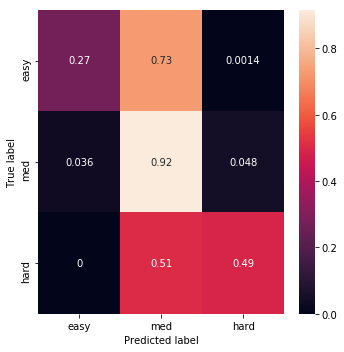

In [12]:
lr = LogisticRegression(C=562341325, solver='lbfgs', multi_class='multinomial', tol=0.01)
lr.fit(train_features, train_target)
lr_pred = lr.predict(test_features)
    
print_metrics(lr_pred)
plot_cm(lr_pred)

/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.6633572977290882
Precision: [0.        0.6633573 0.       ]
Recall: [0. 1. 0.]


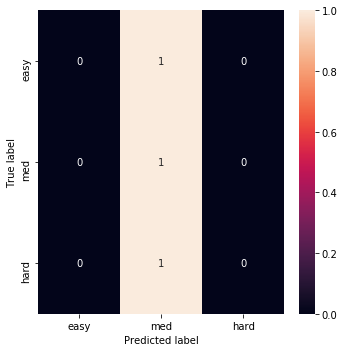

In [18]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=0.5)
sgd.fit(train_features, train_target)
sgd_pred = sgd.predict(test_features)
    
print_metrics(sgd_pred)
plot_cm(sgd_pred)

Accuracy: 0.7101449275362319
Precision: [0.74893617 0.70392035 0.79310345]
Recall: [0.11907984 0.97299157 0.265625  ]


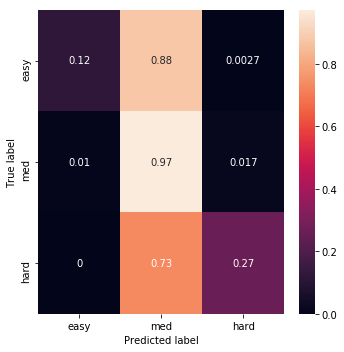

In [14]:
svm = LinearSVC(fit_intercept=True)
svm.fit(train_features, train_target)
svm_pred = svm.predict(test_features)

print_metrics(svm_pred)
plot_cm(svm_pred)

/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy: 0.7197306858381832
Precision: [0.69066667 0.71725921 0.76569678]
Recall: [0.17523681 0.95441252 0.33967391]


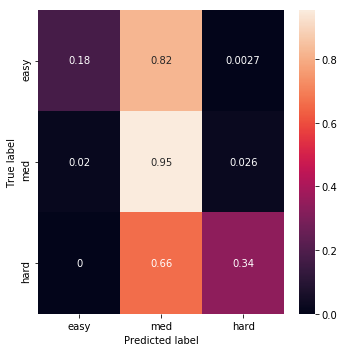

In [15]:
pac = PassiveAggressiveClassifier(C=1.04)
pac.fit(train_features, train_target)
pac_pred = pac.predict(test_features)

print_metrics(pac_pred)
plot_cm(pac_pred)

### Perform Cross Validation across optimized algorithms

In [32]:
models = [('SVC', LinearSVC(fit_intercept=True)),
          ('LR', LogisticRegression(C=562341325, multi_class='multinomial',tol=0.01, solver='lbfgs')),
          ('SGD', SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=0.2)),
          ('PAC', PassiveAggressiveClassifier(C=1.04))]
names = []
all_results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=3)
    results = model_selection.cross_val_score(model, train_features,
                                                 train_target, cv=kfold,
                                                 scoring='accuracy')
    all_results.append(results)
    names.append(name)
    print(f'Acc {name}: {results.mean()} (mean), {results.std()}, (std)')

Acc SVC: 0.9326923076923076 (mean), 0.005116643003348656, (std)
Acc LR: 0.9297161172161172 (mean), 0.006151569982849979, (std)


/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Acc SGD: 0.9189560439560441 (mean), 0.007528884456229581, (std)


/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Acc PAC: 0.9371565934065934 (mean), 0.005793979274195842, (std)


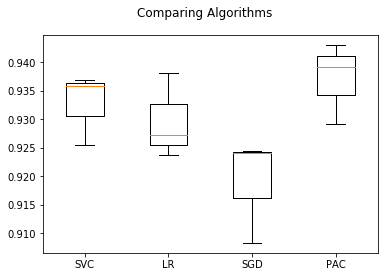

In [34]:
fig = plt.figure()
fig.suptitle('Comparing Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(all_results)
ax.set_xticklabels(names)
plt.show()

### Simplify data set by removing neutral (med) reviewers, retrain model

In [22]:
easy_med_df = df_by_usr[df_by_usr.reviewer_label!='med']

In [23]:
train_data, test_data, train_target, test_target = train_test_split(df_by_usr['text_agg'],
                                                                    df_by_usr['reviewer_label'])

In [24]:
def plot_cm(pred):
    cm = confusion_matrix(test_target,pred, labels=['easy', 'hard'])
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = ['easy', 'hard'],
                      columns = ['easy', 'hard'])

    plt.figure(figsize = (5,5))
    sns.heatmap(df_cm, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [25]:
str_test_data = []
for text in test_data:
    str_test_data.append(str(text))

In [26]:
str_train_data = []
for text in train_data:
    str_train_data.append(str(text))

In [27]:
df_easy_hard = df_by_usr[df_by_usr.reviewer_label!='med']

train_data, test_data, train_target, test_target = train_test_split(df_easy_hard['text_agg'],
                                                                    df_easy_hard['reviewer_label'])

str_test_data = []
for text in test_data:
    str_test_data.append(str(text))
    
str_train_data = []
for text in train_data:
    str_train_data.append(str(text))

vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,2), max_df=0.98) 
train_features = vectorizer.fit_transform(str_train_data)
test_features = vectorizer.transform(str_test_data)

lr = LogisticRegression(C=562341325, solver='lbfgs', tol=0.01)
lr.fit(train_features, train_target)
lr_pred = lr.predict(test_features)

### Print metrics for updated model

Accuracy: 0.9378434065934066
Precision: [0.93884409 0.         0.93679775]
Recall: [0.93947545 0.         0.93614035]


/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


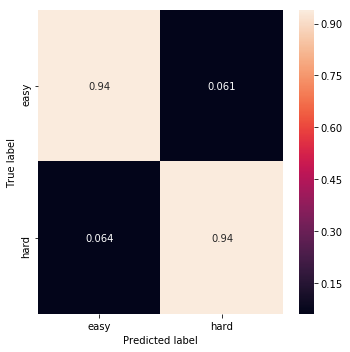

In [28]:
print_metrics(lr_pred)
plot_cm(lr_pred)